In [5]:
import os
from os import walk
import imutils
from imutils import perspective
from imutils import contours
import shutil
import numpy as np
import subprocess
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.spatial import distance
import _pickle as cPickle

print (cv.__version__)

3.4.2


### Convert Video to image

In [6]:
def get_VideoSet ( path ):
    f = []
    d = ""
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
        print("Number of Videos Found: "+str(len(filenames)))
        break
    return f

In [7]:
def generate_ImagesFromVideo ( fileDir, files ):
    sample_freq = 5000
    dirPath = "_tmp"
    outPath = dirPath + "\%08d.jpg"
    if ( not(os.path.exists(dirPath)) ):
        os.mkdir(dirPath)  
        
    num = 0
    for f in files:
        file = fileDir+"\\"+f
        subprocess.call(["ffmpeg", "-i", file, "-vf", "scale=640:480", "-b:v", "5000k", outPath ])
        num += 1
        print("\r>> Processing Video {}".format(num), end='')
        
    for (dirpath, dirnames, filenames) in walk(dirPath): 
        print("\nTotal Number of Images: " + str(len(filenames)))

### Find Detect Objects

In [8]:
def FindObject (img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    d = hsv_img.shape
    org = np.array(d[:2])/2
    
    brown_min = np.array([0, 0, 0], np.uint8)
    brown_max = np.array([145, 255, 255], np.uint8)

    mask_inverse  = cv.inRange(hsv_img, brown_min, brown_max)
    mask = cv.bitwise_not(mask_inverse)

    # find contours in the edge map
    cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
    cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if ( cnts ):
        # sort the contours from left-to-right and initialize the
        # 'pixels per metric' calibration variable
        (cnts, _) = contours.sort_contours(cnts)

        LD = 0
        filter = 0
        print("Number of Contours: " + str(len(cnts)))
        for c in cnts:
            if cv.contourArea(c) > 500:
                C1 = cv.boundingRect(c)
                C2 = np.array(C1[:2])/1
                D = abs(distance.euclidean(org, C2))
                if ( D < LD or LD == 0):
                    filter = c
                    print(len(filter))
                    LD = D

        return(filter)
    else:
        return []
            

In [9]:
def ScrapImage (img, outfile, size):
    cnt = FindObject(img)
    box = cv.boundingRect(cnt)
    x,y,w,h = box
    x -= 50
    if ( x < 0 ): x = 0
    y -= 50
    if ( y < 0 ): y = 0
    w += 100
    h += 100

    cropped = img[y:y+h, x:x+w]
    
    Rx = size/w
    Ry = size/h
    
    resized = cv.resize(cropped, (0,0), fx=Rx, fy=Ry)
    print(outfile)
    try:
        cv.imwrite(outfile, resized)
        return 1
    except ValueError:
        print("Exception")
        return 0

In [10]:
def EasyScrapImage(img,outfile, resize):
    i = img.shape
    start = np.array(i[:2])/4
    start = list(start.astype(int))
    x,y = start
    length = np.array(i[:2])/2
    length = list(length.astype(int))
    w,h = length
    
    # Crop Image
    cropped = img[y:y+h, x:x+w]
    
    Rx = resize/w
    Ry = resize/h
    resized = cv.resize(cropped, (0,0), fx=Rx, fy=Ry)
    try:
        cv.imwrite(outfile, resized)
        return 1
    except ValueError:
        print("Exception")
        return 0

In [11]:
def ScrapeDataImages ( path, outdir, mode=1 ):
    if ( not(os.path.exists(outdir)) ):
            os.mkdir(outdir) 
    num =0
    for (dirpath, dirnames, filenames) in walk(path):
        print( "Files Found: "+str(len(filenames)))
        for file in filenames:
            img = cv.imread(dirpath+"\\"+file)
            num += 1
            print("\r>> Processing Image {}".format(num), end='')
            if ( mode == 0 ):
                ret = ScrapImage(img,outdir+file,obj,64)
            else :
                ret = EasyScrapImage( img,outdir+file,64 )
                
            if ( ret == 0 ):
                break
    print("\nNumber of Files Processed: "+str(num))

In [12]:
def DecomposeRGB(img):
    height,width,color=img.shape
    red = []
    blue = []
    green = []
    for h in range(height):
        redline = []
        blueline = []
        greenline = []
        
        for w in range(width):
            redline.append(img[h][w][2])
            blueline.append(img[h][w][0])
            greenline.append(img[h][w][1])
            
        red.append(np.array(redline, dtype=np.int)) 
        blue.append(np.array(blueline, dtype=np.int))
        green.append(np.array(greenline, dtype=np.int))
        
    color = [np.array(red, dtype=np.int), 
             np.array(green, dtype=np.int),
             np.array(blue, dtype=np.int)]
    return np.array(color, dtype=np.int)
    #color = [red,green, blue ]
    #return color

In [30]:
def CreateDataSetFile ( path, outFile, label ):
    if ( os.path.exists(outFile)):
        os.remove(outFile) 
    fhandle = open(outFile, 'bw+')
    data = {'filenames':[],'labels':[],'data':[]}
    for (dirpath, dirnames, filenames) in walk(path):
        total = len(filenames)
        num = 0
        for file in filenames:
            img = cv.imread(dirpath+"\\"+file)
            
            # decomp_image = DecomposeRGB(img)
            decomp_image = img
            
            data['filenames'].append(file)
            data['labels'].append(label)
            data['data'].append(decomp_image)
            num += 1
            percentage = num/total * 100
            print("\r>> You have finished {0:.2f}%".format(percentage), end='')
    data['data']=np.array(data['data'])
    cPickle.dump(data, fhandle)
    fhandle.close()        
    print("\nDone")     

In [ ]:
### Create Poo Detector DataSet

In [33]:
# Set path to poo data set
path = "rawdata\\poo_det"

# Generate Data set images from Videos
generate_ImagesFromVideo(path, get_VideoSet(path))

# Scrape images for objects
ScrapeDataImages("_tmp","_tmp2\\")
# Create a singe data set
CreateDataSetFile("_tmp2","batch_poo",0)

# Clean up
shutil.rmtree("_tmp2")
shutil.rmtree("_tmp")

In [47]:
# Set path to poo data set
path = "rawdata\\wire_det"
file = "batch_wire"

# Generate Data set images from Videos
generate_ImagesFromVideo(path, get_VideoSet(path))

# Scrape images for objects
ScrapeDataImages("_tmp","_tmp2\\")
# Create a singe data set
CreateDataSetFile("_tmp2",file,0)

# Clean up
shutil.rmtree("_tmp2")
shutil.rmtree("_tmp")

Number of Videos Found: 3
>> Processing Video 3
Total Number of Images: 349
Files Found: 349
>> Processing Image 349
Number of Files Processed: 349
>> You have finished 100.00%
Done


## Clean up

In [35]:
shutil.rmtree("_tmp2")

shutil.rmtree("_tmp")

### Test

In [36]:
class_names = ["poo","ring","wire"]

In [40]:
def OpenDataSet ( file ):
    with open(file, 'rb') as fo:
        dataset = cPickle.load(fo, encoding='bytes')
        print(dataset.keys())
    return dataset

In [45]:
def PlotDataSet(images, labels, smooth=True):

    assert len(images) == len(labels) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    hspace = 0.6
    
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i,:, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[labels[i]]

        # Show true and predicted classes.
        xlabel = "True: {0}".format(cls_true_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [42]:
dataset = OpenDataSet("batch_poo")
print 
# Get the first images from the test-set.
images = dataset['data'][0:9]

# Get the true classes for those images.
labels = dataset['labels'][0:9]

dict_keys(['filenames', 'labels', 'data'])


In [44]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images)))
print(images.shape)

Size of:
- Training-set:		9
(9, 64, 64, 3)


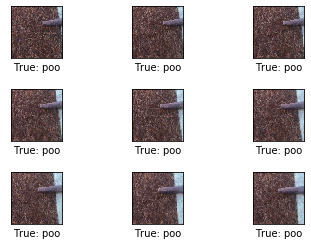

In [46]:
# Plot the images and labels using our helper-function above.
PlotDataSet(images=images, labels=labels, smooth=False)